In [2]:
#* for data manipulation 
import pandas as pd 
import numpy as np 

from disk_analysis_tools import tiling_disk_plots as tdp
from disk_analysis_tools import tiling_disk_utils as tdu

#* sometimes needed for creating bins for histograms 
from astropy.stats import knuth_bin_width

#* for plotting: 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set_theme(style="ticks")
sns.set_context("talk")


sns.set_theme(style="ticks")
sns.set_context("talk")

## Data Import

In [15]:
from pathlib import Path
measurement_folder  = Path.cwd().parent / 'measurements'
lao_meas_files = tdu.read_txt_files(measurement_folder/ 'lao_vac_new_pump')

Split lao from steel files

In [16]:
lao_files = {key: val for key, val in lao_meas_files.items() if key.split('_')[1]=='lao'}

Redefine keys to numeric value of vacuum for sorting later 

In [17]:
lao_files = {key.split('_')[2].split('.')[0]: val for key, val in lao_files.items()}

In [18]:
sorted_lao_raw = {key:val for key, val in sorted(lao_files.items(), key=lambda item: abs(float(tdu.key_sort_helper(item[0]))))}

In [19]:
sorted_lao_pt = {key: tdu.point_table(val) for key, val in sorted_lao_raw.items()}

In [20]:
reference_measurement = sorted_lao_pt['1000mbar']

In [21]:
sorted_lao_pt = {key: tdu.combine_mean_measurements(val, reference_measurement) for key, val in sorted_lao_pt.items()}

In [22]:
sorted_lao_pt.keys()

dict_keys(['70mbar', '100mbar', '200mbar', '300mbar', '400mbar', '500mbar', '600mbar', '700mbar', '800mbar', '900mbar', '1000mbar'])

In [23]:
def calc_ring_means(vac_val, meas_data):
    #? Input to this function are key, value of sorted_steel/lao_pt dict\

    measurement_df = pd.DataFrame()
    #--------------------------------------------
    #? one Hexagon has 4 rings of points. 1 is the most inner one, 4 is the most outer
    ring_1 = [1, 36, 19, 18]
    ring_2 = [2,3,4,33,34,35,20,21,22,15,16,17]
    ring_3 = [9,8,7,6,5, 32,31,30,29,28,
            27,26,25,24,23, 14,13,12,11,10]
    ring_4 = list(range(37, 61, 1))
    rings = [ring_1, ring_2, ring_3, ring_4]
    #----------------------------------------------

    ring_data = {f'data_r{num+1}': meas_data.query(f'point in {ring}') for num, ring in enumerate(rings)} # collect meas data for rings in dict
    rings_mean_est = []
    rings_errors = []

    for ring_nr in range(1,5,1):
        ring_datapoints = ring_data[f'data_r{ring_nr}']['z_mean'].to_numpy()
        ring_mean = np.mean(ring_datapoints)
        ring_err = np.std(ring_datapoints) / np.sqrt(len(ring_datapoints))
        
        rings_mean_est.append(ring_mean*1e3)
        rings_errors.append(ring_err*1e3)

    measurement_df["ring_est"] = rings_mean_est
    measurement_df["ring_err"] = rings_errors
    measurement_df["vacuum_mbar"] = tdu.key_sort_helper(vac_val)
    measurement_df["ring_nr"] = list(range(1,5,1))
    return measurement_df

In [24]:
lao_ring_data_plot = [calc_ring_means(key, val) for key, val in sorted_lao_pt.items()]

In [25]:
lao_ring_data_df = pd.concat(lao_ring_data_plot, axis=0)
lao_ring_data_df.head(5)

,ring_est,ring_err,vacuum_mbar,ring_nr
0,-26.839161,2.394654,70,1
1,-25.217949,3.701620,70,2
2,-16.046154,2.319638,70,3
3,-5.605769,2.848266,70,4
0,-19.372378,6.307317,100,1


In [26]:
def plot_rings_vs_z(ring_data_df, specimen="Lao"): 
    from matplotlib.pyplot import cm 
    color = cm.viridis(np.linspace(0, 1, len(sorted_lao_pt.keys())))

    fig, ax = plt.subplots(1,1, figsize=(7,6))
    ax.set_title(f'{specimen} Hexagon: air pruessure effect')
    ax.set_xlabel('Ring Number')
    ax.set_ylabel('z [µm]')


    for vac, c in zip(ring_data_df["vacuum_mbar"].unique(), color):
        plot_data = ring_data_df.loc[ring_data_df["vacuum_mbar"]==vac,:]
        ax.errorbar(list(range(1,5,1)), plot_data["ring_est"], yerr=plot_data["ring_err"], marker='x', label=f"{vac} mbar", capsize=5, c=c)
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
    # ax.tick_params(labelsize=12)
    ax.set_xticks(range(1,5,1))
    return fig, ax

(<Figure size 504x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Lao Hexagon: air pruessure effect'}, xlabel='Ring Number', ylabel='z [µm]'>)

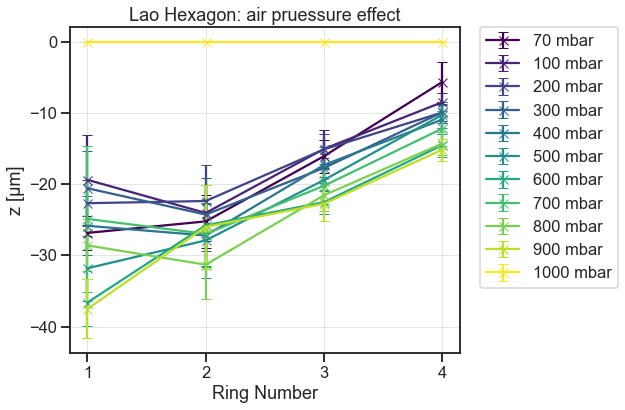

In [27]:
plot_rings_vs_z(lao_ring_data_df)

## Statistical tests

In [30]:
import pingouin as pg 

In [31]:
ring_1_testdata = lao_ring_data_df.loc[lao_ring_data_df.ring_nr==1, :]

In [32]:
ring_1_testdata.reset_index(inplace=True)

In [33]:
ring_1_testdata.keys()

Index(['index', 'ring_est', 'ring_err', 'vacuum_mbar', 'ring_nr'], dtype='object')

In [34]:
ring_1_testdata.drop(ring_1_testdata.index[10], inplace=True)

C:\Users\Domin\AppData\Local\Temp\ipykernel_15032\2489066405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ring_1_testdata.drop(ring_1_testdata.index[10], inplace=True)


In [35]:
ring_1_testdata

,index,ring_est,ring_err,vacuum_mbar,ring_nr
0,0,-26.839161,2.394654,70,1
1,0,-19.372378,6.307317,100,1
2,0,-22.660839,3.190328,200,1
3,0,-20.557692,5.201230,300,1
4,0,-25.837413,4.166339,400,1
5,0,-31.809441,4.591510,500,1
6,0,-36.629371,3.336929,600,1
7,0,-24.868881,10.284560,700,1
8,0,-28.589161,3.664345,800,1
9,0,-37.527972,4.146273,900,1


In [36]:
pg.anova(data=lao_ring_data_df, dv="ring_est", between=["vacuum_mbar","ring_nr"], detailed=True)

C:\Users\Domin\Anaconda3\envs\py_disk_env\lib\site-packages\pingouin\parametric.py:1028: RuntimeWarning: invalid value encountered in double_scalars
  ms_resid = ss_resid / df_resid


,Source,SS,DF,MS,np2
0,vacuum_mbar,1941.385494,10,194.138549,1.0
1,ring_nr,1552.818344,3,517.606115,1.0
2,vacuum_mbar * ring_nr,359.950184,30,11.998339,1.0
3,Residual,0.000000,0,NaN,NaN


In [37]:
vac_testdata = lao_ring_data_df.loc[lao_ring_data_df.vacuum_mbar==70, :]

In [38]:
pg.anova(data=vac_testdata, dv="ring_est", between="ring_nr", detailed=True)

C:\Users\Domin\Anaconda3\envs\py_disk_env\lib\site-packages\pingouin\parametric.py:949: RuntimeWarning: invalid value encountered in double_scalars
  mserror = sserror / ddof2
C:\Users\Domin\Anaconda3\envs\py_disk_env\lib\site-packages\pingouin\parametric.py:956: RuntimeWarning: invalid value encountered in double_scalars
  np2 = ssbetween / (ssbetween + sserror)  # = ssbetween / sstotal


,Source,SS,DF,MS
0,ring_nr,0.0,-1,-0.0
1,Within,0.0,0,NaN


In [39]:
lao_ring_data_df["ring_est_abs"] = -lao_ring_data_df["ring_est"]

In [40]:
pg.anova(data=lao_ring_data_df, dv="ring_est_abs", between=["vacuum_mbar","ring_nr"], detailed=True)

C:\Users\Domin\Anaconda3\envs\py_disk_env\lib\site-packages\pingouin\parametric.py:1028: RuntimeWarning: invalid value encountered in double_scalars
  ms_resid = ss_resid / df_resid


,Source,SS,DF,MS,np2
0,vacuum_mbar,1941.385494,10,194.138549,1.0
1,ring_nr,1552.818344,3,517.606115,1.0
2,vacuum_mbar * ring_nr,359.950184,30,11.998339,1.0
3,Residual,0.000000,0,NaN,NaN


## Steel verformung

In [47]:
from pathlib import Path
measurement_folder  = Path.cwd().parent / 'measurements'
steel_meas_files = tdu.read_txt_files(measurement_folder/ 'steel_vac_new_pump')
steel_files = {key: val for key, val in steel_meas_files.items() if key.split('_')[1]=='steel'}

In [48]:
steel_files = {key.split('_')[2].split('.')[0]: val for key, val in steel_files.items()}

In [49]:
sorted_steel_raw = {key:val for key, val in sorted(steel_files.items(), key=lambda item: abs(float(tdu.key_sort_helper(item[0]))))}

In [50]:
sorted_steel_pt = {key: tdu.point_table(val) for key, val in sorted_steel_raw.items()}

In [51]:
sorted_steel_pt.keys()

dict_keys(['60mbar', '100mbar', '200mbar', '300mbar', '400mbar', '500mbar', '600mbar', '700mbar', '800mbar', '900mbar', '1000mbar', '9999mbar'])

In [52]:
del sorted_steel_pt['1000mbar']

In [53]:
sorted_steel_pt['1000mbar'] = sorted_steel_pt['9999mbar']

In [54]:
del sorted_steel_pt['9999mbar']

In [55]:
reference_measurement_steel = sorted_steel_pt['1000mbar']

In [56]:
sorted_steel_pt = {key: tdu.combine_mean_measurements(val, reference_measurement_steel) for key, val in sorted_steel_pt.items()}

In [57]:
steel_ring_data_plot = [calc_ring_means(key, val) for key, val in sorted_steel_pt.items()]

In [62]:
steel_ring_data_df = pd.concat(steel_ring_data_plot, axis=0)
steel_ring_data_df.head(10)

,ring_est,ring_err,vacuum_mbar,ring_nr
0,-18.839161,1.224183,60,1
1,-19.384615,1.076923,60,2
2,-17.765385,1.394913,60,3
3,-17.016026,2.125631,60,4
0,-17.080420,1.310649,100,1
1,-17.814103,1.000594,100,2
2,-16.123077,1.332840,100,3
3,-15.977564,2.049787,100,4
0,-20.610140,0.869949,200,1
1,-21.397436,0.893160,200,2


(<Figure size 504x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Steel Hexagon: air pruessure effect'}, xlabel='Ring Number', ylabel='z [µm]'>)

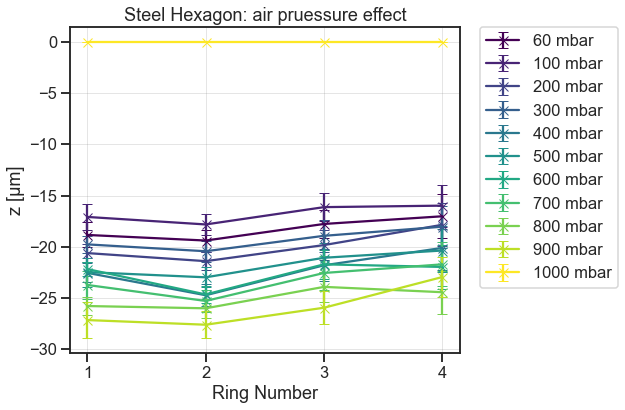

In [59]:
plot_rings_vs_z(steel_ring_data_df, specimen="Steel")

In [60]:
pg.anova(data=steel_ring_data_df, dv="ring_est", between=["vacuum_mbar","ring_nr"], detailed=True)

C:\Users\Domin\Anaconda3\envs\py_disk_env\lib\site-packages\pingouin\parametric.py:1028: RuntimeWarning: invalid value encountered in double_scalars
  ms_resid = ss_resid / df_resid


,Source,SS,DF,MS,np2
0,vacuum_mbar,1992.940827,10,199.294083,1.0
1,ring_nr,45.614553,3,15.204851,1.0
2,vacuum_mbar * ring_nr,14.730204,30,0.491007,1.0
3,Residual,0.000000,0,NaN,NaN
